In [6]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

filename = 'final_sensor_table_sorted.csv'
print(f"Загружаю файл '{filename}'...")

try:
    df = pd.read_csv(filename)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')
    df.set_index('timestamp', inplace=True)
    print("Файл успешно загружен, и индекс преобразован в DatetimeIndex.")
except FileNotFoundError:
    print(f"Файл '{filename}' не найден.")
    raise
    
#создаем признак кластер
cluster_features = [
    'Vessel External Conditions Eastward Wind Velocity',
    'Vessel External Conditions Northward Wind Velocity',
    'Vessel External Conditions Sea Water Temperature',
    'Vessel External Conditions Wave Significant Height',
    'Vessel Hull Aft Draft',
    'Vessel Hull Fore Draft',
    'Vessel Hull MidP Draft',
    'Vessel Hull MidS Draft'
]
cluster_features = [col for col in cluster_features if col in df.columns]

resampler = df[cluster_features].resample('1h')
resampled_mean = resampler.mean()
resampled_std = resampler.std()
resampled_mean.columns = [f"{col}_mean" for col in resampled_mean.columns]
resampled_std.columns = [f"{col}_std" for col in resampled_std.columns]
resampled_data = pd.concat([resampled_mean, resampled_std], axis=1)
resampled_data.fillna(0, inplace=True)

cluster_data = resampled_data.dropna().copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(scaled_data)
cluster_data['cluster'] = cluster_labels

final_df = df.resample('1h').mean()
final_df = final_df.join(cluster_data['cluster'], how='left')
final_df['cluster'].fillna(-1, inplace=True)

print("Признак 'cluster' успешно создан.")

#обучение модели
target_column = 'Main Engine Fuel Oil Inlet Mass Flow'
features_to_use = [
    'Main Engine Fuel Load %',
    'Main Engine Rotational Speed',
    'Vessel Hull Over Ground Speed',
    'Vessel Propeller Shaft Mechanical Power',
    'cluster'
]

subset_df = final_df[[target_column] + features_to_use].dropna()
print(f"Для обучения модели будет использовано {len(subset_df)} строк.")

X = subset_df.drop(target_column, axis=1)
y = subset_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Качество (R-квадрат) модели, использующей кластеры: {r2:.4f}")
print("\nВСЁ!")

Загружаю файл 'final_sensor_table_sorted.csv'...
Файл успешно загружен, и индекс преобразован в DatetimeIndex.


C:\Users\anast\AppData\Local\Temp\ipykernel_6148\2755681891.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df[cluster_features].resample('15T')
C:\Users\anast\AppData\Local\Temp\ipykernel_6148\2755681891.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  final_df = df.resample('15T').mean()
C:\Users\anast\AppData\Local\Temp\ipykernel_6148\2755681891.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.

Признак 'cluster' успешно создан.
Для обучения модели будет использовано 31331 строк.
Качество (R-квадрат) модели, использующей кластеры: 0.9766

ВСЁ!



--- Визуализация результатов модели ---


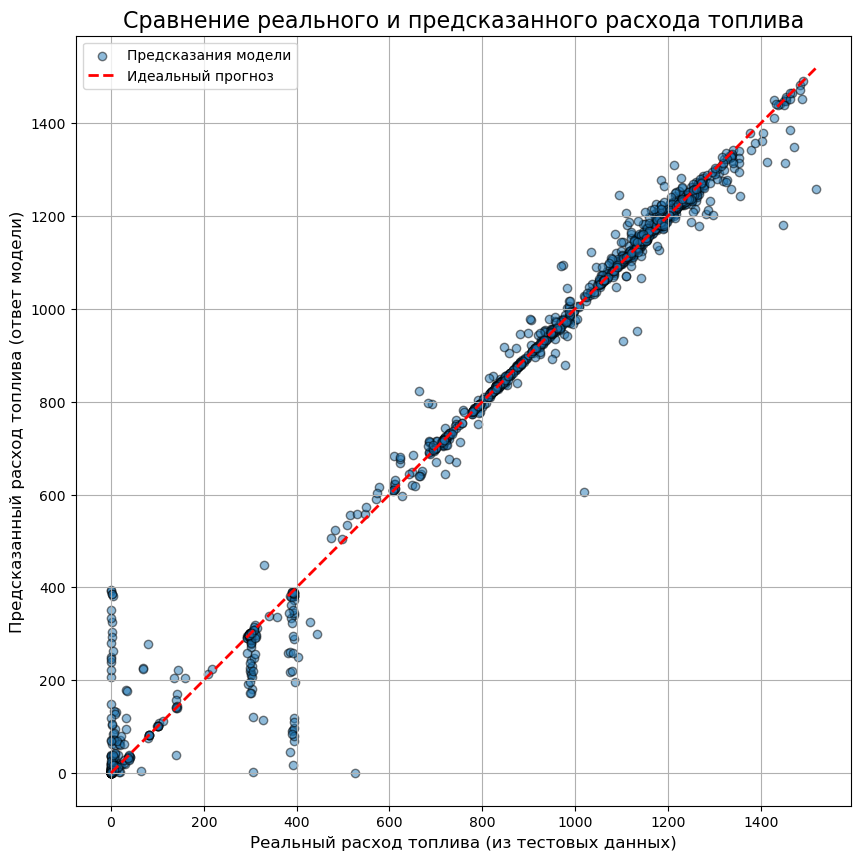

In [11]:
# визуал
import matplotlib.pyplot as plt
if 'y_test' in locals() and 'y_pred' in locals():
    print("\nВизуализация результатов")
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', label='Предсказания модели')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Идеальный прогноз')
    
    plt.title('Сравнение реального и предсказанного расхода топлива', fontsize=16)
    plt.xlabel('Реальный расход топлива (из тестовых данных)', fontsize=12)
    plt.ylabel('Предсказанный расход топлива (ответ модели)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

else:
    print("Ошибка")